In [1]:
import os
import sys
import numpy as np

import matplotlib.pyplot         as plt
import mlem.mlem_reconstruct     as mr
import antea.image.fom_functions as fomf

#sys.stdout = open(os.devnull, "w") ## Prevents from printing

In [2]:
path_to_mlem     = '/Users/carmenromoluque/tofpet3d/lib/libmlem.so'
reco_prefix_base = '/Users/carmenromoluque/nexus_petit_analysis/full-body-phantom-paper/images_reco/'

ths        = [0.25]
tofs       = [140, 150]
n_coinc    = [40579337]
n_iter     = 60
save_every = 2

#sys.stdout = sys.__stdout__ ##Allows printing again

In [3]:
def read_images(th, tof, nc):
    rec = mr.MLEMReconstructor(libpath=path_to_mlem)
    rec.prefix = reco_prefix_base + f'im_th{th}_TOF{tof}ps_{nc}coinc_iter'
    return np.array([rec.read_image(i) for i in range(0, n_iter, save_every)])

from collections import namedtuple

tof_threshold = namedtuple('tof_threshold', 'tof, th')
the_images = {tof_threshold(tof=tof, th=th): read_images(th, tof, nc) 
              for tof in tofs 
              for th, nc in zip(ths, n_coinc)}

Sensitivity matrix not specified: assuming a matrix of 1s.
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Sensitivity matrix not specified: assuming a matrix of 1s.
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes
Read 864000 bytes


In [4]:
the_images[tof_threshold(tof=140, th=0.25)];

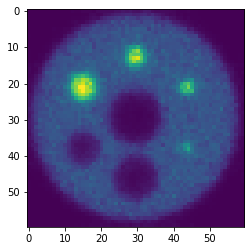

In [5]:
plt.imshow(the_images[(140, 0.25)][6,:,:,29]);

In [6]:
def imshow_slice_integrated_along_z(ax, th, tof, it, z_slice):
    if it < 1:
        it = 1
    image_slice = the_images[tof_threshold(tof=tof, th=th)][int(it/save_every-1),:,:,z_slice]
    im_integrated_along_z = np.sum(image_slice, axis=2).transpose()
    fig0 = ax.imshow(im_integrated_along_z, origin='lower')
    ax.set_title(f'TOF = {tof} ps', fontsize=16)
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    #fig.colorbar(fig0, ax=ax, label='Events')

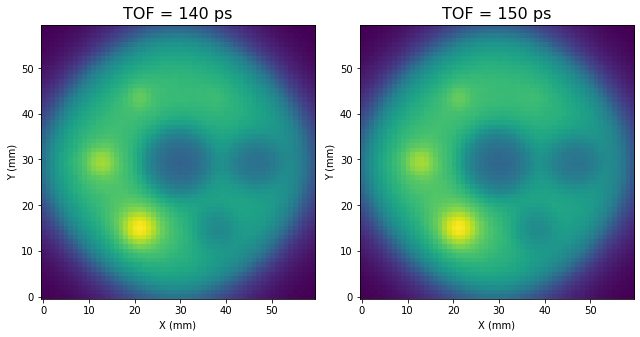

In [7]:
it       = 0
z_slice  = slice(25,35)
fig, axs = plt.subplots(1,2, figsize=(9, 10))
for ax, tof in zip(axs.flatten(), tofs):
    imshow_slice_integrated_along_z(ax, ths[0], it=it, z_slice=z_slice, tof=tof)
plt.tight_layout()
plt.show()

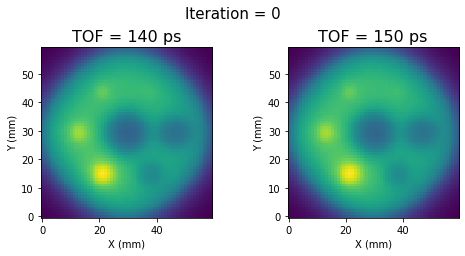

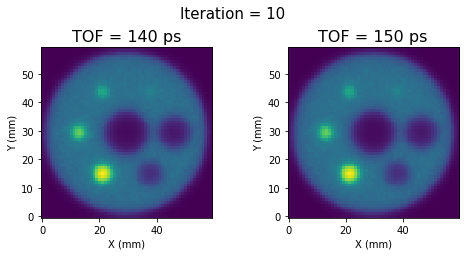

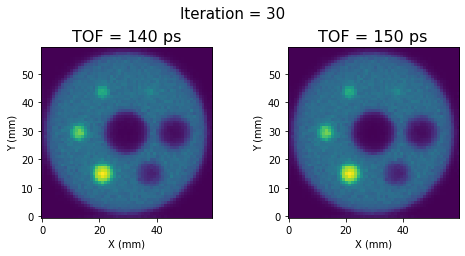

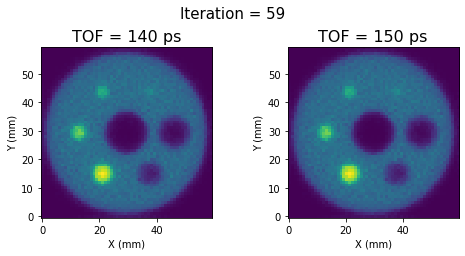

In [8]:
z_slice = slice(25,35)
for it in [0, 10, 30, 59]:
    fig, axs = plt.subplots(1,2, figsize=(7, 3.5))
    fig.suptitle(f'Iteration = {it}', fontsize=15)
    
    for ax, tof in zip(axs.flatten(), tofs):
        imshow_slice_integrated_along_z(ax, ths[0], it=it, z_slice=z_slice, tof=tof)

    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    plt.show()

### Image parameters:

In [9]:
sig_intensity  =  4
bckg_intensity =  1
radial_pos     = 50.
bckg_radius    =  4.
phi0           = np.pi/6
phi_step       = np.pi/3
n_phi          = 6

hot_radii   = [4., 6.5, 8.5, 11.]
cold_radii  = [14., 18.5]
all_radii   = hot_radii + cold_radii

hot_angles  = [np.pi/3, 2*np.pi/3, 3*np.pi/3, 4*np.pi/3]
cold_angles = [5*np.pi/3, 6*np.pi/3]

x_size = y_size = z_size = 180
x_bins = y_bins = z_bins =  60

radii  = hot_radii  + cold_radii
angles = hot_angles + cold_angles

In [10]:
the_images[(150, 0.25)].shape

(30, 60, 60, 60)

## SNR

In [11]:
num_hot     = 4
num_cold    = 2
num_spheres = num_hot + num_cold

sph_thresh_tof = namedtuple('sph_thresh_tof', 'sph, th, tof')
snr_err        = namedtuple('snr_err'       , 'snrs, errs')

def get_snrs(images, tof_and_thr, n_sph):
    calculate_snrs_and_errs = lambda images: fomf.snr3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                        bckg_radius, phi0, phi_step, n_phi, 
                                                        x_size, y_size, z_size,
                                                        x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_snrs_and_errs, images[tof_and_thr]))
    snrs = [r[0] for r in all_images]
    errs = [e[1] for e in all_images]
    print(tof_and_thr, n_sph)
    return snr_err(snrs=snrs, errs=errs)

snrs = {sph_thresh_tof(sph=n_sph, th=th, tof=tof) :
        get_snrs(the_images, tof_threshold(tof=tof, th=th), n_sph)
        for tof   in tofs
        for th    in ths
        for n_sph in range(num_spheres)}

tof_threshold(tof=140, th=0.25) 0
tof_threshold(tof=140, th=0.25) 1
tof_threshold(tof=140, th=0.25) 2
tof_threshold(tof=140, th=0.25) 3
tof_threshold(tof=140, th=0.25) 4
tof_threshold(tof=140, th=0.25) 5
tof_threshold(tof=150, th=0.25) 0
tof_threshold(tof=150, th=0.25) 1
tof_threshold(tof=150, th=0.25) 2
tof_threshold(tof=150, th=0.25) 3
tof_threshold(tof=150, th=0.25) 4
tof_threshold(tof=150, th=0.25) 5


In [12]:
## Configuration for plots ##
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = 10, 7.5

## colors
tableau = [( 31, 119, 180), (174, 199, 232), (255, 127,  14), (255, 187, 120),
           ( 44, 160,  44), (152, 223, 138), (214,  39,  40), (255, 152, 150),
           (148, 103, 189), (197, 176, 213), (140,  86,  75), (196, 156, 148),
           (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
           (188, 189,  34), (219, 219, 141), ( 23, 190, 207), (158, 218, 229), 
           (218,  60,  78), (35,  180, 203)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau)):
    r, g, b = tableau[i]
    tableau[i] = (r / 255., g / 255., b / 255.)

light_red  = tableau[20]
light_blue = tableau[21]

##           tof = 140ps   tof = 150ps
sph_colors=[[light_blue,  'cornflowerblue' ], #sph 0 hot
            [light_red,     'firebrick'    ], #sph 1 hot
            ['yellowgreen', 'green'        ], #sph 2 hot
            ['sandybrown',  'darkgoldenrod'], #sph 3 hot
            ['navy',        'blue'         ], #sph 4 cold
            ['silver',      'grey'         ]] #sph 5 cold

colors = {sph_thresh_tof(sph=n_sph, th=ths[0], tof=tof): color
          for n_sph, colors in enumerate(sph_colors) 
          for color, tof    in zip(colors, tofs)}

In [13]:
from typing import Sequence
from typing import Dict

sel_n_iter = 60
def plot_snr_sphs(snrs:    Dict[sph_thresh_tof, snr_err], 
                  spheres: Sequence[int], 
                  th:      int, 
                  colors:  Dict[sph_thresh_tof, 'Color'],
                  tofs:    Sequence[float]):
    images_wanted = int(sel_n_iter/save_every)
    for tof in tofs:
        for n_sphere in spheres:
            sphere = snrs  [sph_thresh_tof(sph=n_sphere, th=th, tof=tof)]
            color  = colors[sph_thresh_tof(sph=n_sphere, th=th, tof=tof)]
            plt.errorbar(x = list(range(0, sel_n_iter, save_every)), 
                         y =    sphere.snrs[:images_wanted], 
                         yerr = sphere.errs[:images_wanted], 
                         xerr = None,
                         color = color, 
                         marker = 's', 
                         capsize = 3, 
                         label = f'sph{n_sphere}, ({all_radii[n_sphere]} rad), TOF={tof} ps')

### Hot spheres:

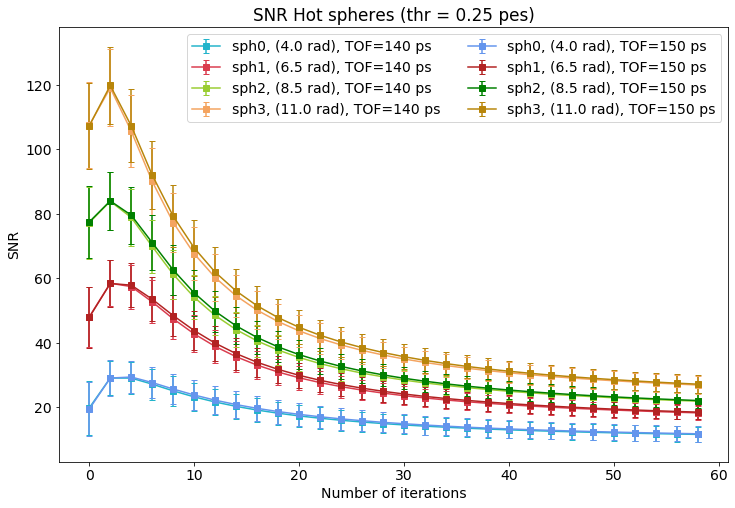

In [14]:
plt.figure(figsize=(12,8))
plot_snr_sphs(snrs, range(num_hot), ths[0], colors, tofs=tofs)
plt.title(f'SNR Hot spheres (thr = {ths[0]} pes)')
plt.xlabel('Number of iterations')
plt.ylabel('SNR')
plt.legend(loc=1, fontsize=14, ncol=2);

### Cold spheres:

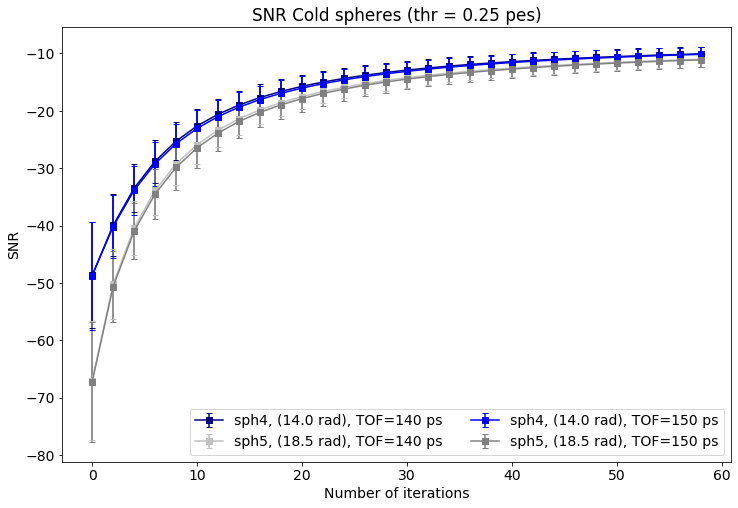

In [15]:
plt.figure(figsize=(12,8))
plot_snr_sphs(snrs, range(4,6), ths[0], colors, tofs=tofs)
plt.title(f'SNR Cold spheres (thr = {ths[0]} pes)')
plt.xlabel('Number of iterations')
plt.ylabel('SNR')
plt.legend(loc=4, fontsize=14, ncol=2);

## CRC

In [16]:
crc_err = namedtuple('crc_err', 'crcs, errs')
sig_intensity  =  4
bckg_intensity =  1

def get_crcs(images, tof_and_thr, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_hot3d(images, sig_intensity, bckg_intensity, 
                                                            radii[n_sph], radial_pos, angles[n_sph], 
                                                            bckg_radius, phi0, phi_step, n_phi, 
                                                            x_size, y_size, z_size,
                                                            x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[tof_and_thr]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(tof_and_thr, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs = {sph_thresh_tof(sph=n_sph, th=th, tof=tof) :
        get_crcs(the_images, tof_threshold(tof=tof, th=th), n_sph)
        for tof   in tofs
        for th    in ths
        for n_sph in range(4)}

tof_threshold(tof=140, th=0.25) 0
tof_threshold(tof=140, th=0.25) 1
tof_threshold(tof=140, th=0.25) 2
tof_threshold(tof=140, th=0.25) 3
tof_threshold(tof=150, th=0.25) 0
tof_threshold(tof=150, th=0.25) 1
tof_threshold(tof=150, th=0.25) 2
tof_threshold(tof=150, th=0.25) 3


In [17]:
def get_crcs_cold(images, tof_and_thr, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_cold3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                             bckg_radius, phi0, phi_step, n_phi, 
                                                             x_size, y_size, z_size,
                                                             x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[tof_and_thr]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(tof_and_thr, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs_cold = {sph_thresh_tof(sph=n_sph, th=th, tof=tof) :
             get_crcs_cold(the_images, tof_threshold(tof=tof, th=th), n_sph)
             for tof   in tofs
             for th    in ths
             for n_sph in range(4,6)}

tof_threshold(tof=140, th=0.25) 4
tof_threshold(tof=140, th=0.25) 5
tof_threshold(tof=150, th=0.25) 4
tof_threshold(tof=150, th=0.25) 5


In [18]:
sel_n_iter = 60
def plot_crc_sphs(crcs:    Dict[sph_thresh_tof, crc_err], 
                  spheres: Sequence[int], 
                  th:      int, 
                  colors:  Dict[sph_thresh_tof, 'Color'],
                  tofs:    Sequence[int]):
    images_wanted = int(sel_n_iter/save_every)
    for tof in tofs:
        for n_sphere in spheres:
            sphere = crcs  [sph_thresh_tof(sph=n_sphere, th=th, tof=tof)]
            color  = colors[sph_thresh_tof(sph=n_sphere, th=th, tof=tof)]
            plt.errorbar(x = list(range(0, sel_n_iter, save_every)), 
                         y =    sphere.crcs[:images_wanted], 
                         yerr = sphere.errs[:images_wanted], 
                         xerr = None,
                         color = color, 
                         marker = 's', 
                         capsize = 4, 
                         label = f'sph{n_sphere}, ({all_radii[n_sphere]} rad), thr={th} pes')

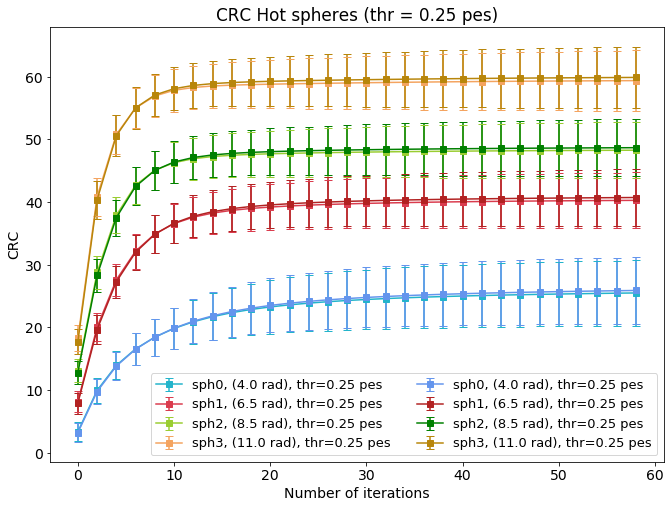

In [19]:
plt.figure(figsize=(11,8))
plot_crc_sphs(crcs, range(num_hot), ths[0], colors, tofs=tofs)
plt.title(f'CRC Hot spheres (thr = {ths[0]} pes)')
plt.xlabel('Number of iterations')
plt.ylabel('CRC')
plt.legend(loc=4, fontsize=13, ncol=2);

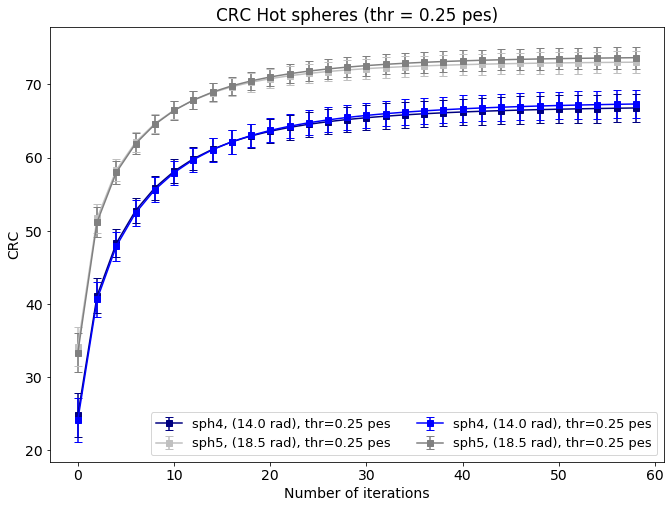

In [20]:
plt.figure(figsize=(11,8))
plot_crc_sphs(crcs_cold, range(4, 6), ths[0], colors, tofs=tofs)
plt.title(f'CRC Hot spheres (thr = {ths[0]} pes)')
plt.xlabel('Number of iterations')
plt.ylabel('CRC')
plt.legend(loc=4, fontsize=13, ncol=2);

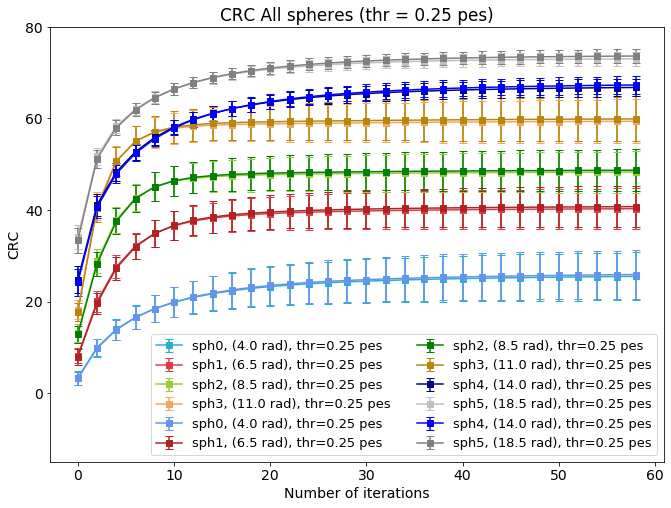

In [21]:
plt.figure(figsize=(11,8))
plot_crc_sphs(crcs, range(num_hot), ths[0], colors, tofs=tofs)
plot_crc_sphs(crcs_cold, range(4, 6), ths[0], colors, tofs=tofs)
plt.title(f'CRC All spheres (thr = {ths[0]} pes)')
plt.xlabel('Number of iterations')
plt.ylabel('CRC')
plt.ylim(-15, 80)
plt.legend(loc=4, fontsize=13, ncol=2);

In [22]:
the_images[(140, 0.25)].shape

(30, 60, 60, 60)